In [1]:
#
"""
___________________________
Dott. Ing. Nicola Lombardi
___________________________


Bibliography: 

ResearchGate: https://www.researchgate.net/publication/382851188_A_whole_method_to_do_Data_Analysis
Kaggle: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews



====================================================
| Author of the Project - Engineer Nicola Lombardi |
====================================================
| MSc. in Telecommunications and Internet of Things |
|Dottore Magistrale | Telecomunicazioni | HW ENGINEER Telit Cinterion SpA, Trieste, Sgonico, TS
| Friuli Venezia Giulia |
|Professional Profile                   |  it.linkedin.com/in/nicola-lombardi-09046b205


====--------
Università degli Studi di Cagliari (UniCa, Sardegna, Cagliari, CA)
Dipartimento di Ingegneria Elettrica ed Elettronica
Piazza d'Armi, 09123 Cagliari
====--------
"""


"""
L'analisi del sentiment, o opinion mining, è il processo di analisi di 
grandi volumi di testo per determinare se il tono emotivo del testo è positivo, negativo o neutro.


__________________

About Dataset
__________________

This dataset consists of a few million Amazon customer reviews (input text) and star ratings (output labels) for learning how 
to train fastText for sentiment analysis.

The idea here is a dataset is more than a toy - real business data on a reasonable scale - but can be trained in minutes on a
modest laptop.
Content

The fastText supervised learning tutorial requires data in the following format:

__label__<X> __label__<Y> ... <Text>

where X and Y are the class names. No quotes, all on one line.

In this case, the classes are __label__1 and __label__2, and there is only one class per row.

MOS = Mean Opinion Score: MOS = 1/N sum(xi)  where xi is in {1,2,3,4,5}



__label__1 corresponds to 1- and 2-star reviews, and 
__label__2 corresponds to 4- and 5-star reviews.

Esse saranno considerate come r'^__label__(\d)' con la mappatura:  
            train_data['Sentiment'].map({'1': 'Negative', '2': 'Positive'})

(3-star reviews i.e. reviews with neutral sentiment were not included in the original),

The review titles, followed by ':' and a space, are prepended to the text.

Most of the reviews are in English, but there are a few in other languages, like Spanish.




==============================
DOCUMENTATION ABOUT BUILTINS
==============================



______________________________
--- pandas: apply ---
______________________________
df = pd.DataFrame([[4, 9]] * 3, columns=['A', 'B'])

df
   A  B
0  4  9
1  4  9
2  4  9

df.apply(np.sqrt)
     A    B
0  2.0  3.0
1  2.0  3.0
2  2.0  3.0



def clean_text(text):
    text = re.sub(r'^[^ ]+ ', '', text)  # Rimuovi label iniziale
    text = re.sub(r'[^\w\s]', '', text)  # Rimuovi punteggiatura
    text = text.lower().strip()         # Trasforma in lowercase e rimuovi spazi extra
    return text

# Pulizia del testo
train_data['Cleaned_Review'] = train_data['Review'].apply(clean_text)
test_data['Cleaned_Review'] = test_data['Review'].apply(clean_text)






"""


"\nL'analisi del sentiment, o opinion mining, è il processo di analisi di \ngrandi volumi di testo per determinare se il tono emotivo del testo è positivo, negativo o neutro.\n\n\n__________________\n\nAbout Dataset\n__________________\n\nThis dataset consists of a few million Amazon customer reviews (input text) and star ratings (output labels) for learning how \nto train fastText for sentiment analysis.\n\nThe idea here is a dataset is more than a toy - real business data on a reasonable scale - but can be trained in minutes on a\nmodest laptop.\nContent\n\nThe fastText supervised learning tutorial requires data in the following format:\n\n__label__<X> __label__<Y> ... <Text>\n\nwhere X and Y are the class names. No quotes, all on one line.\n\nIn this case, the classes are __label__1 and __label__2, and there is only one class per row.\n\nMOS = Mean Opinion Score: MOS = 1/N sum(xi)  where xi is in {1,2,3,4,5}\n\n\n\n__label__1 corresponds to 1- and 2-star reviews, and \n__label__2 co

In [2]:
"""
Qui ti faccio vedere come organizzare un file .ipynb in cui faccio una Sentiment Analysis 
delle reviews di Amazon come da progetto. 

In particolare vorrei:
1- Exploratory Data Analysis
2- Opinion Mining
3- Metrics computation, matrix correlation etc.

"""

!pip install wordcloud
!pip install textblob

In [3]:
# Importazione delle librerie necessarie
import pandas as pd # dataframes
import numpy as np  # calcolo
import seaborn as sns # graphics
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from textblob import TextBlob
import datetime


new_plot_test_number = "###############################################################################\n"
header = """
                        #####################################\n
                               Train Test Data Preview
                        #####################################\n"""
clock_string = f"[{datetime.datetime.now()}]"



# Configurazione generale
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Visualizzare tutte le colonne
pd.set_option('display.max_columns', None)


In [4]:
# 1. Exploratory Data Analysis
"""
(C) Nicola Lombardi
From: https://www.researchgate.net/publication/382851188_A_whole_method_to_do_Data_Analysis

Exploratory Data Analysis A series of steps where Data Features will be highlighted using libraries to plot patterns.
"""



def load_sentiment_analysis_data(train_file: str, test_file: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Carica i dati dai file di addestramento e test per l'analisi del sentiment.
    
    Args:
        train_file (str): Percorso al file di addestramento.
        test_file (str): Percorso al file di test.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: Due DataFrame contenenti i dati di addestramento e test.

    Raises:
        FileNotFoundError: Se uno dei due file non esiste.
        PermissionError: Se non si ha il permesso di leggere uno dei due file.
    """
    # Controllo se il file di addestramento esiste
    if not os.path.exists(train_file):
        raise FileNotFoundError(f"Errore: il file di addestramento non esiste o il percorso è errato: {train_file}")
    else:
        print(f"Il file di addestramento esiste: {train_file}")

    # Controllo se il file di test esiste
    if not os.path.exists(test_file):
        raise FileNotFoundError(f"Errore: il file di test non esiste o il percorso è errato: {test_file}")
    else:
        print(f"Il file di test esiste: {test_file}")
    
    # Lettura dei file in DataFrame
    try:
        train_data = pd.read_csv(train_file, header=None, sep='\n', names=['Review'])
        test_data = pd.read_csv(test_file, header=None, sep='\n', names=['Review'])
    except PermissionError as e:
        raise PermissionError(f"Errore: permesso negato durante l'apertura dei file.\n{e}")
    except Exception as e:
        raise Exception(f"Errore durante la lettura dei file:\n{e}")

    # Anteprima dei dati
    print(header)
    print(new_plot_test_number)
    print("Train Data Preview:")
    print(train_data.head())
    print(new_plot_test_number)
    print("\nTest Data Preview:")
    print(test_data.head())

    # Restituzione dei due DataFrame
    return train_data, test_data





In [5]:
train_file_path = r'train_ft.txt'
test_file_path = r'test_ft.txt'

train_df, test_df = load_sentiment_analysis_data(train_file_path, test_file_path)

Il file di addestramento esiste: train_ft.txt
Il file di test esiste: test_ft.txt

                        #####################################

                               Train Test Data Preview
                        #####################################

###############################################################################

Train Data Preview:
                                              Review
0  __label__2 Stuning even for the non-gamer: Thi...
1  __label__2 The best soundtrack ever to anythin...
2  __label__2 Amazing!: This soundtrack is my fav...
3  __label__2 Excellent Soundtrack: I truly like ...
4  __label__2 Remember, Pull Your Jaw Off The Flo...
###############################################################################


Test Data Preview:
                                              Review
0  __label__2 Great CD: My lovely Pat has one of ...
1  __label__2 One of the best game music soundtra...
2  __label__1 Batteries died within a year ...: I...
3  _

In [6]:
# 1.1 Preprocessing dei Dati

# Funzione per pulire le recensioni
import re

def clean_text(text):
    """
    Pulisce una singola recensione rimuovendo etichette iniziali, punteggiatura,
    spazi extra e trasformando il testo in minuscolo per non dar problemi e non
    dover gestire sia Lowercase che Uppercase separatemente.
    
    Args:
        text (str): La recensione da pulire.
    
    Returns:
        str: La recensione pulita.
    """
    text = re.sub(r'^[^ ]+ ', '', text)  # Rimuovi label iniziale
    text = re.sub(r'[^\w\s]', '', text)  # Rimuovi punteggiatura
    text = text.lower().strip()         # Trasforma in lowercase e rimuovi spazi extra
    
    return text


def preprocessing(train_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Prepara i dati di addestramento e test effettuando le seguenti operazioni:
    1. Pulisce le recensioni con la funzione `clean_text`.
    2. Aggiunge una colonna 'Sentiment' ai dati di addestramento.

    Args:
        train_data (pd.DataFrame): DataFrame con i dati di addestramento.
        test_data (pd.DataFrame): DataFrame con i dati di test.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: DataFrame di addestramento e test preprocessati.
    """
    # Pulizia delle recensioni
    train_data['Cleaned_Review'] = train_data['Review'].apply(clean_text)
    test_data['Cleaned_Review'] = test_data['Review'].apply(clean_text)
    

    # Aggiunta della colonna 'Sentiment' ai dati di addestramento
    train_data['Sentiment'] = train_data['Review'].str.extract(r'^__label__(\d)')
    train_data['Sentiment'] = train_data['Sentiment'].map({'1': 'Negative', '2': 'Positive'})
    train_data['Sentiment'] = train_data['Sentiment'].fillna('Unknown')
    

    # Stampa per verifica
    print("Train Data dopo il preprocessing:")
    print(train_data.head())
    print("\nTest Data dopo il preprocessing:")
    print(test_data.head())

    return train_data, test_data


In [7]:
# Preprocessa i dati
train_df, test_df = preprocessing(train_df, test_df)


Train Data dopo il preprocessing:
                                              Review  \
0  __label__2 Stuning even for the non-gamer: Thi...   
1  __label__2 The best soundtrack ever to anythin...   
2  __label__2 Amazing!: This soundtrack is my fav...   
3  __label__2 Excellent Soundtrack: I truly like ...   
4  __label__2 Remember, Pull Your Jaw Off The Flo...   

                                      Cleaned_Review Sentiment  
0  stuning even for the nongamer this sound track...  Positive  
1  the best soundtrack ever to anything im readin...  Positive  
2  amazing this soundtrack is my favorite music o...  Positive  
3  excellent soundtrack i truly like this soundtr...  Positive  
4  remember pull your jaw off the floor after hea...  Positive  

Test Data dopo il preprocessing:
                                              Review  \
0  __label__2 Great CD: My lovely Pat has one of ...   
1  __label__2 One of the best game music soundtra...   
2  __label__1 Batteries died within a

In [8]:
# Distribuzione delle recensioni positive/negative

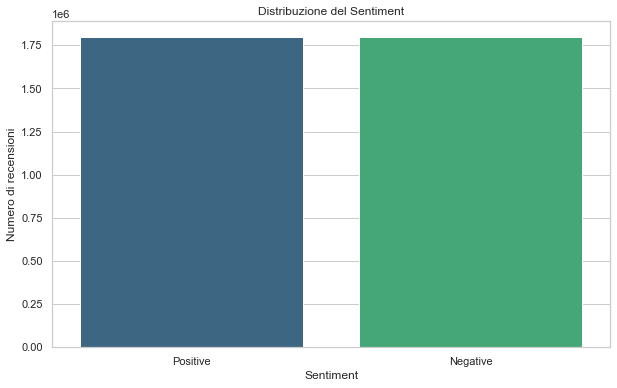

In [9]:
# Visualizzazione della distribuzione del Sentiment
sns.countplot(data=train_df, x='Sentiment', palette='viridis')
plt.title('Distribuzione del Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Numero di recensioni')
plt.show()

In [10]:
"""# Generazione di WordCloud
positive_reviews = ' '.join(train_df[train_df['Sentiment'] == 'Positive']['Cleaned_Review'])
negative_reviews = ' '.join(train_df[train_df['Sentiment'] == 'Negative']['Cleaned_Review'])

# WordCloud per recensioni positive
wc = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wc, interpolation='bilinear')
plt.title('WordCloud - Positive Reviews')
plt.axis('off')
plt.show()

# WordCloud per recensioni negative
wc = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.imshow(wc, interpolation='bilinear')
plt.title('WordCloud - Negative Reviews')
plt.axis('off')
plt.show()"""

"# Generazione di WordCloud\npositive_reviews = ' '.join(train_df[train_df['Sentiment'] == 'Positive']['Cleaned_Review'])\nnegative_reviews = ' '.join(train_df[train_df['Sentiment'] == 'Negative']['Cleaned_Review'])\n\n# WordCloud per recensioni positive\nwc = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)\nplt.imshow(wc, interpolation='bilinear')\nplt.title('WordCloud - Positive Reviews')\nplt.axis('off')\nplt.show()\n\n# WordCloud per recensioni negative\nwc = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)\nplt.imshow(wc, interpolation='bilinear')\nplt.title('WordCloud - Negative Reviews')\nplt.axis('off')\nplt.show()"

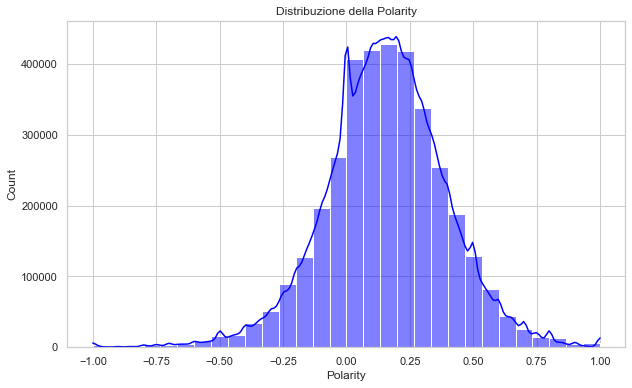

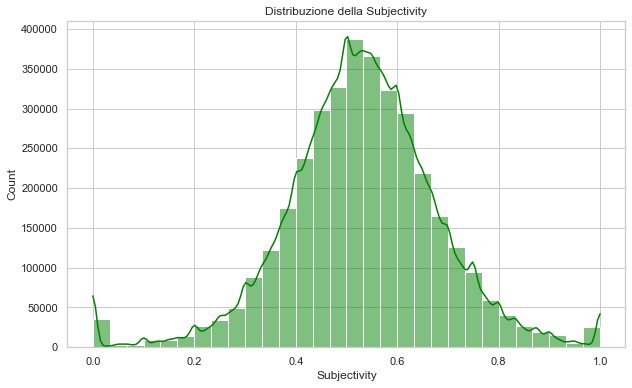

In [11]:

# Analisi del sentiment con TextBlob
train_df['Polarity'] = train_df['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df['Subjectivity'] = train_df['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Visualizzazione Polarity e Subjectivity
sns.histplot(train_df['Polarity'], bins=30, kde=True, color='blue')
plt.title('Distribuzione della Polarity')
plt.show()

sns.histplot(train_df['Subjectivity'], bins=30, kde=True, color='green')
plt.title('Distribuzione della Subjectivity')
plt.show()



In [12]:

# Divisione in feature (X) e target (y)
X = train_data['Cleaned_Review']
y = train_data['Sentiment']

# Trasformazione dei dati in TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# Divisione train/test
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Modello di classificazione semplice
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

# Valutazione del modello
y_pred = model.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Matrice di confusione
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



NameError: name 'train_data' is not defined